In [1]:
from optionCombo import optionModel,preInit

C:\Users\5565\AppData\Local\Programs\Python\Python310\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [4]:
global currency
global url
currency = 'BTC'
#url = 'https://www.deribit.com/api/v2/public/'
#option_data,expirList = collect_clean_data()

# COLLECT DELTA EXCHANGE OPTION DATA

In [3]:
import requests
headers = {
  'Accept': 'application/json'
}

r = requests.get('https://api.delta.exchange/v2/tickers', params={'contract_types':'call_options'

}, headers = headers)
r = r.json()['result']
r2 = requests.get('https://api.delta.exchange/v2/tickers', params={'contract_types':'put_options'

}, headers = headers)
r2 = r2.json()['result']
r.extend(r2)
data = r
option_data = pd.DataFrame(data)
option_data['infos'] = option_data['symbol'].apply(lambda x:x.split('-'))
option_data['expiration'] = option_data['infos'].apply(lambda x:pd.to_datetime(x[3]))#pd.to_datetime(option_data['expiration'])#
option_data['is_call'] = option_data['infos'].apply(lambda x:x[0])
option_data['K'] = option_data['infos'].apply(lambda x:x[2])
option_data['ticker'] = option_data['infos'].apply(lambda x:x[1])
option_data['askIv'] = option_data['quotes'].apply(lambda x:x['ask_iv'])
option_data['bidIv'] = option_data['quotes'].apply(lambda x:x['bid_iv'])
option_data[['K','bidIV','askIV']] = option_data[['K','bidIv','askIv']].astype('float')
option_data['expiry'] = option_data['expiration'].apply(lambda x: (pd.to_datetime(x) - datetime.now()) / (pd.to_timedelta('365d')))
option_data = option_data.loc[option_data.ticker==currency][['is_call','K','askIV','bidIV','expiry','expiration']]
expirList = option_data.sort_values(by=['expiration'])['expiration'].unique()


In [5]:
expirList

<DatetimeArray>
['2023-02-07 00:00:00', '2023-03-07 00:00:00', '2023-04-07 00:00:00',
 '2023-07-07 00:00:00', '2023-07-14 00:00:00', '2023-07-21 00:00:00',
 '2023-07-28 00:00:00', '2023-08-25 00:00:00', '2023-09-29 00:00:00']
Length: 9, dtype: datetime64[ns]

In [6]:
'''
choose a expiry date, doesn't support mutiple expiry dates at the moment
'''
expirDate = '2023-07-28 00:00:00'

In [7]:
'''
The option DataFrame should have the following structure:
'''
option_data

,is_call,K,askIV,bidIV,expiry,expiration
0,C,32000.0,0.458250,0.451473,0.069795,2023-07-28
1,C,31000.0,0.443821,0.432318,0.069795,2023-07-28
2,C,30000.0,0.438526,0.425558,0.069795,2023-07-28
3,C,29000.0,0.444510,0.421835,0.069795,2023-07-28
4,C,28000.0,0.457458,0.420459,0.069795,2023-07-28
...,...,...,...,...,...,...
827,P,32000.0,0.449622,0.323329,-0.237054,2023-04-07
828,P,29400.0,0.337446,0.318358,-0.237054,2023-04-07
829,P,29200.0,0.364728,0.342952,-0.237054,2023-04-07
832,P,32200.0,0.492579,0.330781,-0.237054,2023-04-07


# COLLECT OHLCV DATA To Calculate EXPECTED PRICE RANGE

In [8]:
import ccxt
def fetchprice(symbol,exchange = 'binance'):
    res = {}
    exchange = getattr(ccxt, exchange)()


    while True:
        try:
            data = exchange.fetch_ohlcv(symbol, '15m', None, 1000)
            header = ["Timestamp", "open", "high", "low", "close", "volume"]
            df = pd.DataFrame(data, columns=header)
            df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
            break
        except Exception as e:
            print(e)
            time.sleep(1)
    for i in range(20):
        while True:
            try:
                since = df.Timestamp.values[0] - 1000*15*60*1000
                data = exchange.fetch_ohlcv(symbol, '15m', since, 1000)
                header = ["Timestamp", "open", "high", "low", "close", "volume"]
                df1 = pd.DataFrame(data, columns=header)
                df1 = df1[["Timestamp", "open", "high", "low", "close", "volume"]]
                df = pd.concat([df1,df]).reset_index(drop=True)
                break
            except Exception as e:
                print(e)
                time.sleep(1)
    df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'] / 1000, unit="s")
    df["open"] = pd.to_numeric(df["open"])
    df["high"] = pd.to_numeric(df["high"])
    df["low"] = pd.to_numeric(df["low"])
    df["close"] = pd.to_numeric(df["close"])
    df["volume"] = pd.to_numeric(df["volume"])
    return df

In [10]:
pricedata = fetchprice('BTCUSDT')

In [11]:
'''
The price DataFrame should have the following structure:
'''
pricedata

,Timestamp,open,high,low,close,volume
0,2022-11-25 10:45:00,16482.91,16495.96,16463.28,16477.50,1608.76109
1,2022-11-25 11:00:00,16477.93,16533.00,16470.03,16525.83,2727.97450
2,2022-11-25 11:15:00,16525.83,16591.43,16520.53,16544.26,4425.97614
3,2022-11-25 11:30:00,16544.26,16564.98,16526.26,16535.22,2663.05428
4,2022-11-25 11:45:00,16534.66,16539.83,16510.77,16531.64,1845.03584
...,...,...,...,...,...,...
20995,2023-07-02 03:30:00,30542.85,30544.08,30476.11,30517.27,222.59707
20996,2023-07-02 03:45:00,30517.28,30520.00,30476.93,30509.31,229.84559
20997,2023-07-02 04:00:00,30509.30,30518.95,30476.00,30509.24,244.29851
20998,2023-07-02 04:15:00,30509.24,30535.85,30504.00,30535.85,161.08395


In [12]:
'''

This section of the code is responsible for the pre-computation step. It prepares and computes the 
necessary data for further calculations related to the option combinations.

In this step, you need to select the expiry date for your option strategy and provide the required 
option and price data.
'''
preOption,joined1,price = preInit.Prep( expirDate, optionDf = option_data, priceDf = pricedata,Bound=None, interval=3,strikePriceRange=0.3)

In [13]:
'''
This section of the code is responsible for iterating through all possible option combinations. In 
the "optiontypes" parameter, a two-dimensional list should be provided, where each element represents 
a call option (1) or a put option (-1). For example, [[1,1,1],[-1,-1,1,1]] indicates that there are 
three call options followed by two put options and two call options.

The "tradetypes" parameter determines whether to sell or buy the corresponding options. For instance, 
if "optiontypes" is [[1,1,1]], the "tradetypes" should be [[1,-1,1]] or [[[1,-1,1],[1,1,1]]]. 
By default, "tradetypes" is set to None, which includes all possible combinations.

The "maxquantity" parameter represents the maximum quantity allowed for a single option trade amount.
'''

model = optionModel.option_model(price, joined1,preOption,optiontypes = [[1,1,1,1],[-1,-1,1,1],[-1,-1,-1,-1]], maxquantity=4)  # Init
df = model.options_model_finder()                                                                           # start looping

100%|█████████████████████████████████████████████████████████████████████████| 344160/344160 [06:03<00:00, 946.56it/s]


In [16]:
'''

The output of the code snippet contains all the possible combinations based on the provided 
parameters. You have the flexibility to filter the results according to your specific requirements.

'''
df['v/t'] = abs(df['mean_vega']/df['mean_theta'])
df['bb'] = df['probal']*df['mean_theta']/df['maxRisk']
temp = df.sort_values(by=['maxRisk','probal','bb','RR','v/t','mean_vega','mean_theta'], ascending=[True,False,False,False,True,False,False])
temp


,para,stra,maxRisk,probal,RR,wv,wp,bv,bp,wd,...,delta_starting,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium,minReward,v/t,bb
106705,"[30503.71, [0.06979534622428336, 0.06979534622...",C_26000_-4__C_28000_4__C_33000_1__C_35000_-1,3.099232e-01,0.700000,3.226606,0.85,30200.2403,0.85,22519.4996,0.000000,...,0.4795,0.303836,0.782726,4.030242,-5.092726,18.479540,31642.2855,-1892.7717,0.791372,-11.502553
287755,"[30503.71, [0.06979534622428336, 0.06979534622...",P_26000_-1__P_28000_1__P_33000_4__P_35000_-4,3.219678e-01,0.733333,3.105900,0.85,32760.4871,1.15,46415.1371,0.000000,...,0.4566,0.308315,0.769874,-0.409383,-1.786679,19.229816,31958.4546,-1948.4156,0.229131,-4.069448
106703,"[30503.71, [0.06979534622428336, 0.06979534622...",C_26000_-4__C_28000_4__C_32000_1__C_34000_-1,3.338246e-01,0.200000,2.995585,0.85,30200.2403,0.85,22519.4996,0.000000,...,0.4511,0.296714,0.779461,4.006917,-5.034881,17.944697,32016.4607,-2002.2099,0.795832,-3.016483
90145,"[30503.71, [0.06979534622428336, 0.06979534622...",C_26000_-3__C_28000_3__C_33000_1__C_35000_-1,3.344746e-01,0.700000,2.989764,0.85,31907.0715,0.85,22519.4996,0.000000,...,0.3273,0.237048,0.602375,2.928219,-3.842874,14.586971,23972.1476,-1503.8484,0.761987,-8.042500
287485,"[30503.71, [0.06979534622428336, 0.06979534622...",P_26000_-1__P_28000_1__P_33000_3__P_35000_-3,3.453056e-01,0.733333,2.895985,0.85,32760.4871,1.15,46415.1371,0.000000,...,0.3098,0.240236,0.593476,-0.031531,-1.638842,15.096905,24119.7168,-1540.0468,0.019240,-3.480447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161497,"[30503.71, [0.06979534622428336, 0.06979534622...",P_28000_4__P_29000_2__C_32000_-1__C_33000_-4,9.016798e+04,0.400000,0.482207,1.15,47268.5528,1.15,22519.4996,25.475301,...,2.9608,4.356511,1.521724,-2.043311,3.885690,44.321658,6613.7407,-72341.9585,0.525855,0.000017
136603,"[30503.71, [0.06979534622428336, 0.06979534622...",P_27000_2__P_29000_4__C_32000_-3__C_34000_-2,1.127443e+05,0.266667,0.482177,1.15,47268.5528,1.15,22519.4996,25.475301,...,3.0488,4.357181,1.423527,-2.080944,3.907600,42.643403,7002.7741,-72343.4083,0.532538,0.000009
27232,"[30503.71, [0.06979534622428336, 0.06979534622...",C_26000_2__C_29000_-3__C_31000_-4__C_34000_4,2.148459e+05,0.366667,0.232948,0.85,47268.5528,0.85,29346.8246,25.475301,...,1.2883,1.272844,1.368508,-0.827085,-0.690614,31.238983,22880.6935,-24268.4397,1.197608,-0.000001
25069,"[30503.71, [0.06979534622428336, 0.06979534622...",C_27000_2__C_28000_-2__C_34000_-2__C_35000_-3,7.579837e+05,0.500000,0.032605,1.15,47268.5528,0.85,28493.4090,25.475301,...,0.8085,2.598640,2.330704,-36.495880,34.272716,56.063093,15427.7895,-61342.6825,1.064867,0.000023


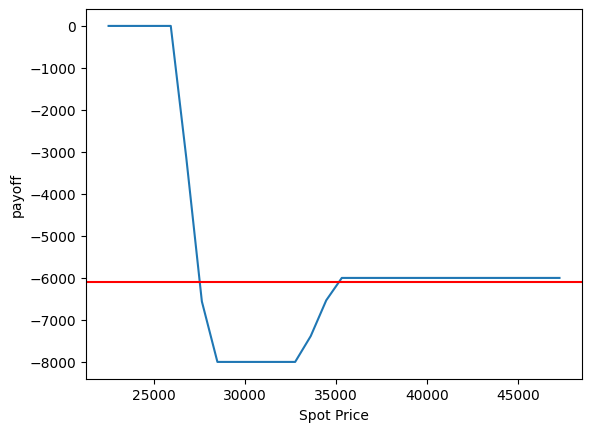

net premium -6107.228299999998
premium 31642.2855
Risk Reward 3.2266058817341707
probal 0.7
lowest possible premium -8000.000000000002
max risk 0.3099231937997151
worst case, vol: 0.85 price: 30200.2403 days: 0.0
best case, vol: 0.85 price: 22519.4996 days: 0.0
min theta -85.9278
min vega -43.512499999999996
C_26000_-4__C_28000_4__C_33000_1__C_35000_-1


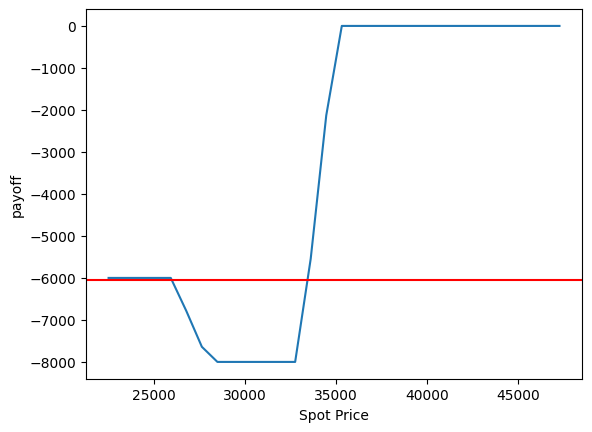

net premium -6051.584400000002
premium 31958.4546
Risk Reward 3.105900199115632
probal 0.7333333333333333
lowest possible premium -8000.000000000001
max risk 0.32196784696582914
worst case, vol: 0.85 price: 32760.4871 days: 0.0
best case, vol: 1.15 price: 46415.1371 days: 25.475301371863427
min theta -82.2325
min vega -53.309799999999996
P_26000_-1__P_28000_1__P_33000_4__P_35000_-4


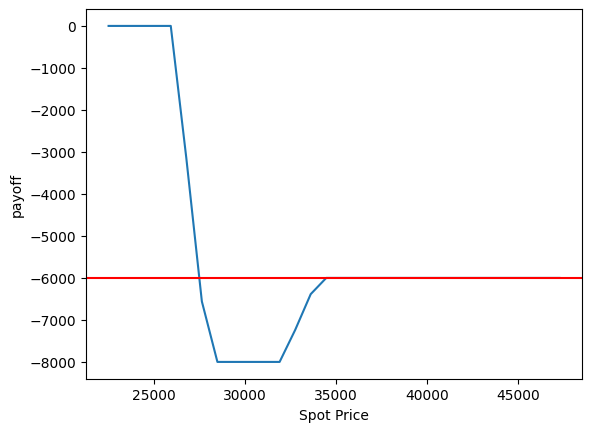

net premium -5997.790099999998
premium 32016.460699999996
Risk Reward 2.995585078267762
probal 0.2
lowest possible premium -8000.000000000002
max risk 0.3338246031650898
worst case, vol: 0.85 price: 30200.2403 days: 0.0
best case, vol: 0.85 price: 22519.4996 days: 0.0
min theta -83.45299999999999
min vega -43.22849999999999
C_26000_-4__C_28000_4__C_32000_1__C_34000_-1


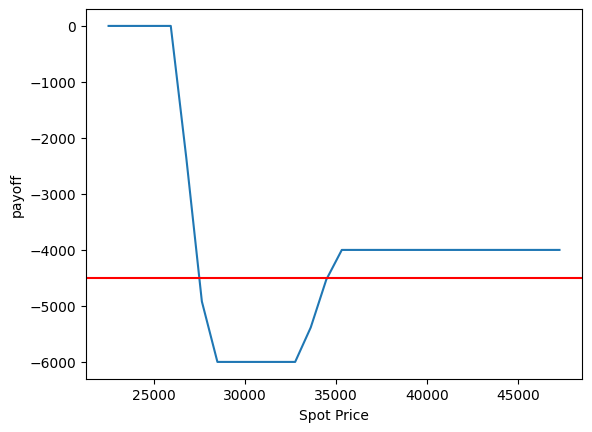

net premium -4496.151599999998
premium 23972.1476
Risk Reward 2.989763861836065
probal 0.7
lowest possible premium -6000.000000000002
max risk 0.3344745759907215
worst case, vol: 0.85 price: 31907.0715 days: 0.0
best case, vol: 0.85 price: 22519.4996 days: 0.0
min theta -68.2056
min vega -32.5857
C_26000_-3__C_28000_3__C_33000_1__C_35000_-1


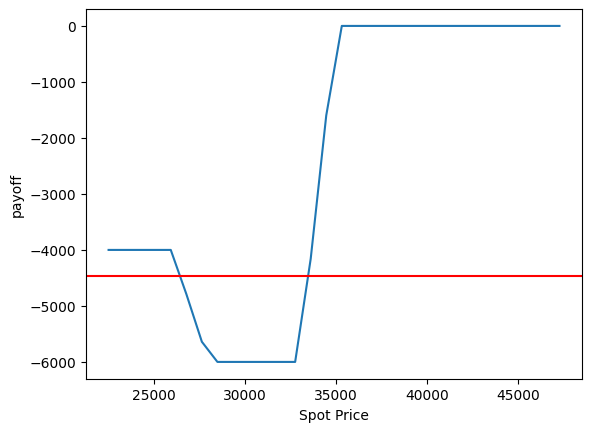

net premium -4459.953200000002
premium 24119.716800000002
Risk Reward 2.895985498622512
probal 0.7333333333333333
lowest possible premium -6000.000000000001
max risk 0.3453055964802497
worst case, vol: 0.85 price: 32760.4871 days: 0.0
best case, vol: 1.15 price: 46415.1371 days: 25.475301371863427
min theta -65.94569999999999
min vega -39.8519
P_26000_-1__P_28000_1__P_33000_3__P_35000_-3


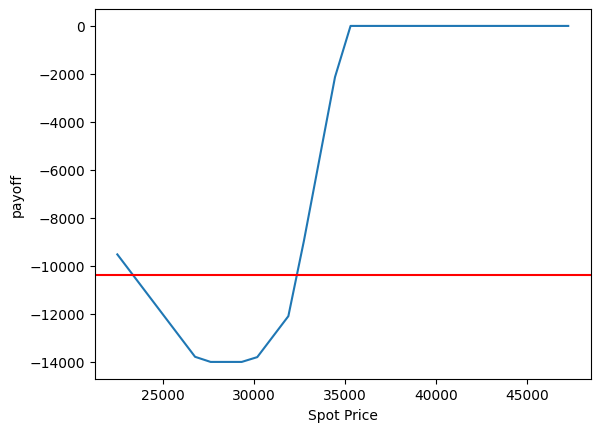

net premium -10396.8201
premium 27324.6559
Risk Reward 2.885456843273354
probal 0.6666666666666666
lowest possible premium -14000.000000000002
max risk 0.3465655715250859
worst case, vol: 0.85 price: 28493.409 days: 0.0
best case, vol: 0.85 price: 35320.734 days: 0.0
min theta -115.6714
min vega -87.6661
P_27000_1__P_30000_1__P_32000_3__P_35000_-4


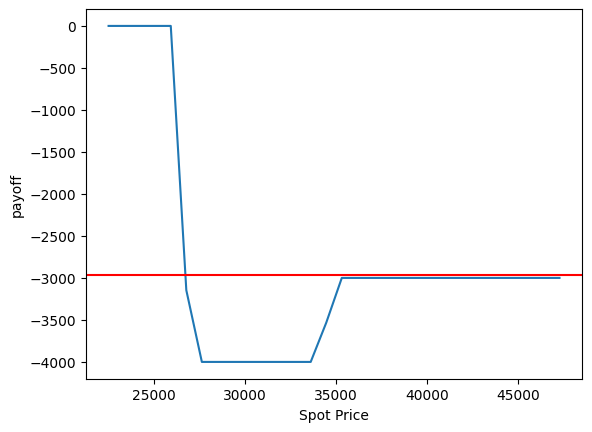

net premium -2962.271999999998
premium 34787.241799999996
Risk Reward 2.854574609146123
probal 0.16666666666666666
lowest possible premium -4000.000000000002
max risk 0.3503148934331501
worst case, vol: 0.85 price: 30200.2403 days: 0.0
best case, vol: 1.15 price: 22519.4996 days: 25.475301371863427
min theta -62.5185
min vega -21.934999999999995
C_26000_-4__C_27000_4__C_34000_1__C_35000_-1


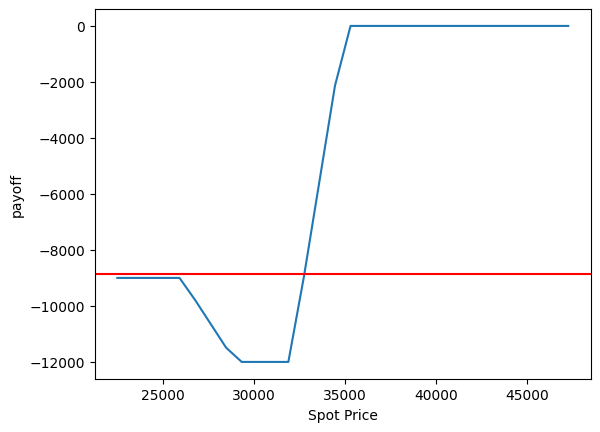

net premium -8869.7679
premium 29140.2711
Risk Reward 2.8335815417649073
probal 0.5666666666666667
lowest possible premium -12000.0
max risk 0.3529102604815622
worst case, vol: 0.85 price: 29346.8246 days: 0.0
best case, vol: 0.85 price: 35320.734 days: 0.0
min theta -97.7672
min vega -78.1057
P_26000_-1__P_29000_1__P_32000_4__P_35000_-4


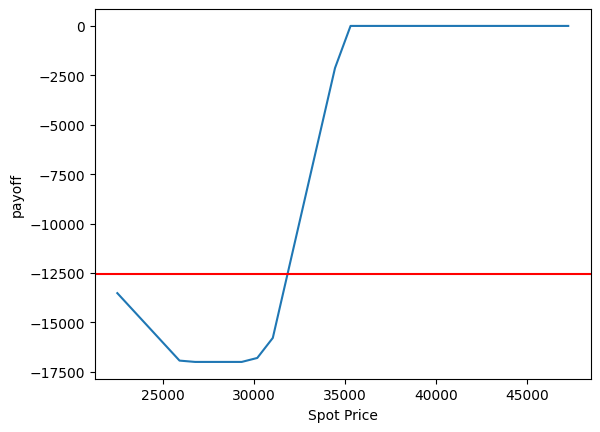

net premium -12543.035100000001
premium 25178.4409
Risk Reward 2.8142548531176437
probal 0.6333333333333333
lowest possible premium -17000.000000000004
max risk 0.3553338457930332
worst case, vol: 0.85 price: 26786.5778 days: 0.0
best case, vol: 0.85 price: 35320.734 days: 0.0
min theta -122.6499
min vega -105.0084
P_26000_1__P_30000_1__P_31000_3__P_35000_-4


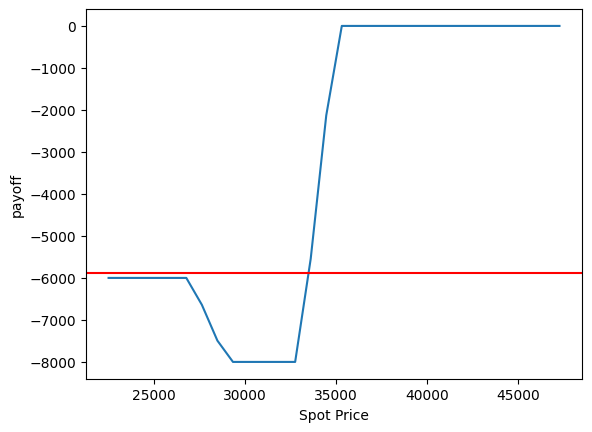

net premium -5881.339800000002
premium 32339.3462
Risk Reward 2.775971248244529
probal 0.5666666666666667
lowest possible premium -8000.000000000001
max risk 0.3602342785907386
worst case, vol: 0.85 price: 32760.4871 days: 0.0
best case, vol: 1.15 price: 46415.1371 days: 25.475301371863427
min theta -80.28930000000001
min vega -52.66199999999999
P_27000_-1__P_29000_1__P_33000_4__P_35000_-4


In [17]:
'''
The plotted graph consists of two lines: a blue line representing the payoff curve and a red line 
representing the net premium.

The blue line represents the payoff curve, which depicts the potential profit or loss at expiration 
for the option combination. It shows how the payoff varies with different underlying asset prices. 
The shape of the curve provides insights into the risk and potential returns of the option combination.

The red line represents the net premium, which is the total premium paid or received for the option 
combination. It indicates the initial cost or income associated with entering the option positions.

By visualizing the payoff curve and net premium, you can gain a better understanding of the potential 
outcomes and financial implications of the option combination under different market scenarios. 
This can assist in evaluating the risk-reward profile and making informed decisions regarding option 
trading strategies.
'''
for para in temp.para[:10]:
    model.model_plot(para)

In [ ]:
price